In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

In [2]:
if IN_COLAB:
    !git clone https://github.com/LucaLemos/UFRPE_AprendizagemReforco
    sys.path.append("/content/UFRPE_AprendizagemReforco")

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [3]:
if IN_COLAB:
    # for saving videos
    !apt-get install ffmpeg
    !pip install gymnasium==1.0.0   # conferir se precisa
    #!pip install tianshou # Para criar o Replay_Buffer
    #!pip install d3rlpy==2.7.0
    # clone repository

In [4]:
import numpy as np
import gymnasium as gym
import torch

from util.algorithms import run_expected_sarsa, run_sarsa

In [5]:
# Hiperparâmetros
GAMMA = 0.95  # Fator de desconto
TAU = 0.005      # Taxa de atualização da target_network
ALPHA = 0.5      # Peso do termo CQL
ITERATIONS = 5000  # Número de iterações do CQL
DATASET_SIZE = 1_000_000  # Tamanho do conjunto de dados (replay buffer)
BATCH_SIZE = 128  # Tamanho do batch para treinamento da rede neural
LEARNING_RATE = 1e-3  # Taxa de aprendizado para o otimizador

# Extra: 
TARGET_UPDATE_FREQ = 200  # Atualizar a target network a cada 2 iterações

In [6]:
# Passo 1: Coletar um conjunto fixo de transições (Replay Buffer)
ENV_NAMES = ["FrozenLake-v1", "Taxi-v3", "CliffWalking-v0"]
ENVS_REPLAY_BUFFER = []
for i, env_name in enumerate(ENV_NAMES):
  env = gym.make(env_name, render_mode="rgb_array")
  sum_rewards_per_ep, _, transitions = run_sarsa(env, DATASET_SIZE, LEARNING_RATE, GAMMA)
  ENVS_REPLAY_BUFFER.append((env_name, env, transitions, sum_rewards_per_ep))


Run sarsa in <TimeLimit<OrderEnforcing<PassiveEnvChecker<FrozenLakeEnv<FrozenLake-v1>>>>>
Episódio 0 terminou com recompensa 0.0 na transição 11
Episódio 100 terminou com recompensa 0.0 na transição 1673
Episódio 200 terminou com recompensa 0.0 na transição 3188
Episódio 300 terminou com recompensa 0.0 na transição 4802
Episódio 400 terminou com recompensa 0.0 na transição 6348
Episódio 500 terminou com recompensa 0.0 na transição 7541
Episódio 600 terminou com recompensa 0.0 na transição 8889
Episódio 700 terminou com recompensa 0.0 na transição 10320
Episódio 800 terminou com recompensa 0.0 na transição 11664
Episódio 900 terminou com recompensa 0.0 na transição 13131
Episódio 1000 terminou com recompensa 0.0 na transição 14515
Episódio 1100 terminou com recompensa 0.0 na transição 15955
Episódio 1200 terminou com recompensa 0.0 na transição 17425
Episódio 1300 terminou com recompensa 0.0 na transição 18919
Episódio 1400 terminou com recompensa 0.0 na transição 20508
Episódio 1500 te

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, batch_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, state):
        #print(f"[QNetwork] forward with State: {state}") 
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        #print(f"[QNetwork] Return action = {x}")
        return x

In [8]:
# Função para converter estados em tensores one-hot
def to_one_hot(state, num_states):
    one_hot = np.zeros(num_states)
    one_hot[state] = 1
    return torch.FloatTensor(one_hot)

In [9]:
def sample_batch(replay_buffer, batch_size, states_dim):
    """ Retorna um batch aleatório de transições do buffer. """
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]

    states, actions, rewards, next_states, terminateds, truncateds, dones, infos = zip(*batch)

    states = torch.stack([to_one_hot(s, states_dim) for s in states])
    next_states = torch.stack([to_one_hot(ns, states_dim) for ns in next_states])
    actions = torch.LongTensor(actions).unsqueeze(1)
    rewards = torch.FloatTensor(rewards).unsqueeze(1)
    dones = torch.FloatTensor(dones).unsqueeze(1)

    #print(f"    States = {states}")
    return states, actions, rewards, next_states, dones

In [10]:
def cql_loss(q_network, states, actions, target_q_values, alpha=ALPHA):
    """ Calcula a perda CQL. """
    #print(f"[LOSS] States = {states}")
    q_values = q_network(states).gather(1, actions)

    #print(f"    Q_values = {q_values}")
    # Calcula a penalidade CQL
    all_q_values = q_network(states)
    logsumexp_q = torch.logsumexp(all_q_values, dim=1, keepdim=True)
    penalty = logsumexp_q - q_values

    # Cálculo final da perda
    loss = torch.mean((q_values - target_q_values) ** 2) + alpha * torch.mean(penalty)
    print(f"    Loss = {loss}")
    return loss


In [11]:
import random
def train_cql(q_network, target_network, replay_buffer, states_dim, q_values_means, rewards_variances, batch_size=64, optimizer=None):
    print("[TRAIN] Iniciando")
    # Amostra um batch de transições do replay buffer
    #batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = sample_batch(replay_buffer, batch_size, states_dim)
    #print(f"    States = {states}")

    # Calcula os Q-values para as ações tomadas.
    q_values = q_network(states).gather(1, actions)
    
    #print(f"    Q_values = {q_values}")
    #print(f"Q Values in Train: {q_values}")
    # Calcula o Q-valor alvo
    with torch.no_grad():
        next_q_values = target_network(next_states).max(1, keepdim=True)[0]  # Mantendo a dimensão do batch
        target_q_values = rewards + GAMMA * next_q_values * (1 - dones)
        #print(f"    Target_values = {target_q_values}")
    # Calcula a perda usando a função CQL
    loss = cql_loss(q_network, states, actions, target_q_values, ALPHA)

    # Atualiza a rede neural
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Métricas adicionais
    q_values_means.append(q_values.mean().item())  # Valor Q médio
    rewards_variances.append(torch.var(rewards).item())   # Variância das recompensas
    print("[Train] Finalizando")
    return loss, q_values_means, rewards_variances

In [12]:
def evaluate_policy(q_network, env, states_dim, num_episodes=100, max_steps=50000):
    print("[Evaluate] Iniciando")
    total_rewards = []
    for i in range(num_episodes):
        print(f"    Episode {i}:")
        state, _ = env.reset()
        done = False
        total_reward = 0
        step = 0  # Para limitar os passos por episódio
        while not done and step < max_steps:
            state_one_hot = to_one_hot(state, states_dim).unsqueeze(0)  # Adiciona dimensão de batch
            q_values = q_network(state_one_hot)
            action = torch.argmax(q_values).item()
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            step += 1
        total_rewards.append(total_reward)
        print(f"        Total reward: {total_reward}")
    print("[Evaluate] Finalizando")
    return np.mean(total_rewards)

In [13]:
def update_target_network(q_network, target_network, tau=0.005):
    """ Atualiza os pesos do target network usando soft update. """
    for target_param, param in zip(target_network.parameters(), q_network.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

In [14]:
def train_and_evaluate(q_network, target_network, env, replay_buffer, states_dim, batch_size, optimizer, iterations=10000, evaluate_every=1000, target_update_every=100, max_steps=10000):
    losses = []
    avg_rewards = []
    q_values_means = []
    rewards_variances = []
    for iteration in range(iterations):
        print(f"[For] Iteration {iteration}:")
        loss, q_values_means, rewards_variances = train_cql(q_network, target_network, replay_buffer, states_dim, q_values_means, rewards_variances, batch_size, optimizer)
        if (iteration + 1) % target_update_every == 0:
            update_target_network(q_network, target_network, TAU)
        
        if (iteration + 1) % evaluate_every == 0:
            losses.append(loss)
            avg_reward = evaluate_policy(q_network, env, states_dim)
            avg_rewards.append(avg_reward)
            print(f"Iteração {iteration}, Perda: {loss.item()}, Recompensa Média: {avg_reward}")
    return losses, avg_rewards

# FrozenLake

In [15]:
# Listas para armazenar métricas
frozen = ENVS_REPLAY_BUFFER.pop(0)
states_dim = frozen[1].observation_space.n  # Número de estados
actions_dim = frozen[1].action_space.n      # Número de ações
q_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network.load_state_dict(q_network.state_dict())  # Inicializa como cópia
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)


In [16]:
import torch.optim as optim
loss, av_rewards = train_and_evaluate(q_network, target_network, frozen[1], frozen[2], states_dim, BATCH_SIZE, optimizer, ITERATIONS, 1000, TARGET_UPDATE_FREQ)

[For] Iteration 0:
[TRAIN] Iniciando
    Loss = 0.7499240636825562
[Train] Finalizando
[For] Iteration 1:
[TRAIN] Iniciando
    Loss = 0.7238668203353882
[Train] Finalizando
[For] Iteration 2:
[TRAIN] Iniciando
    Loss = 0.7195629477500916
[Train] Finalizando
[For] Iteration 3:
[TRAIN] Iniciando
    Loss = 0.7143352627754211
[Train] Finalizando
[For] Iteration 4:
[TRAIN] Iniciando
    Loss = 0.7049106359481812
[Train] Finalizando
[For] Iteration 5:
[TRAIN] Iniciando
    Loss = 0.6792778372764587
[Train] Finalizando
[For] Iteration 6:
[TRAIN] Iniciando
    Loss = 0.6687466502189636
[Train] Finalizando
[For] Iteration 7:
[TRAIN] Iniciando
    Loss = 0.6696444153785706
[Train] Finalizando
[For] Iteration 8:
[TRAIN] Iniciando
    Loss = 0.661005973815918
[Train] Finalizando
[For] Iteration 9:
[TRAIN] Iniciando
    Loss = 0.6792935729026794
[Train] Finalizando
[For] Iteration 10:
[TRAIN] Iniciando
    Loss = 0.6609821319580078
[Train] Finalizando
[For] Iteration 11:
[TRAIN] Iniciando
    L

In [17]:
av_rewards

[np.float64(0.12),
 np.float64(0.13),
 np.float64(0.08),
 np.float64(0.09),
 np.float64(0.09)]

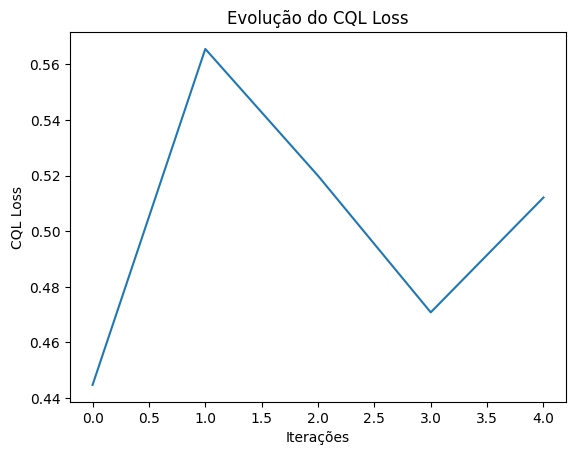

In [18]:
import matplotlib.pyplot as plt

# Extraindo os valores numéricos dos tensores de perda
loss_values = [l.item() for l in loss]

# Plotando a evolução da perda
plt.plot(loss_values)
plt.xlabel("Iterações")
plt.ylabel("CQL Loss")
plt.title("Evolução do CQL Loss")
plt.show()



In [19]:
print("Q-values médios:", np.array(av_rewards).mean().item())
print("Q-values variância:", np.array(av_rewards).var().item())


Q-values médios: 0.10200000000000001
Q-values variância: 0.00037600000000000003


In [20]:
torch.save(q_network.state_dict(), "q_network_FrozenLake.pth")
print("Modelo salvo como q_network_FrozenLake.pth")

Modelo salvo como q_network_FrozenLake.pth


In [ ]:
q_network.load_state_dict(torch.load("q_network_FrozenLake.pth"))
q_network.eval()  # Coloca a rede em modo de inferência

# Taxi

In [21]:
# Listas para armazenar métricas
taxi = ENVS_REPLAY_BUFFER.pop(0)
states_dim = taxi[1].observation_space.n  # Número de estados
actions_dim = taxi[1].action_space.n      # Número de ações
q_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network.load_state_dict(q_network.state_dict())  # Inicializa como cópia
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)

In [ ]:
import torch.optim as optim
loss, av_rewards = train_and_evaluate(q_network, target_network, taxi[1], taxi[2], states_dim, BATCH_SIZE, optimizer, ITERATIONS, 1000, TARGET_UPDATE_FREQ)

        Step 4800, State: 48, Action: 3, Reward: -1
        Step 4900, State: 48, Action: 3, Reward: -1
        Step 5000, State: 48, Action: 3, Reward: -1
        Step 5100, State: 48, Action: 3, Reward: -1
        Step 5200, State: 48, Action: 3, Reward: -1
        Step 5300, State: 48, Action: 3, Reward: -1
        Step 5400, State: 48, Action: 3, Reward: -1
        Step 5500, State: 48, Action: 3, Reward: -1
        Step 5600, State: 48, Action: 3, Reward: -1
        Step 5700, State: 48, Action: 3, Reward: -1
        Step 5800, State: 48, Action: 3, Reward: -1
        Step 5900, State: 48, Action: 3, Reward: -1
        Step 6000, State: 48, Action: 3, Reward: -1
        Step 6100, State: 48, Action: 3, Reward: -1
        Step 6200, State: 48, Action: 3, Reward: -1
        Step 6300, State: 48, Action: 3, Reward: -1
        Step 6400, State: 48, Action: 3, Reward: -1
        Step 6500, State: 48, Action: 3, Reward: -1
        Step 6600, State: 48, Action: 3, Reward: -1
        Step

In [ ]:
import matplotlib.pyplot as plt

# Extraindo os valores numéricos dos tensores de perda
loss_values = [l.item() for l in loss]

# Plotando a evolução da perda
plt.plot(loss_values)
plt.xlabel("Iterações")
plt.ylabel("CQL Loss")
plt.title("Evolução do CQL Loss")
plt.show()



In [ ]:
print("Q-values médios:", np.array(av_rewards).mean().item())
print("Q-values variância:", np.array(av_rewards).var().item())


In [ ]:
torch.save(q_network.state_dict(), "q_network_Taxi.pth")
print("Modelo salvo como q_network_Taxi.pth")

# Cliff

In [22]:
# Listas para armazenar métricas
cliff = ENVS_REPLAY_BUFFER.pop(0)
states_dim = cliff[1].observation_space.n  # Número de estados
actions_dim = cliff[1].action_space.n      # Número de ações
q_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network = QNetwork(states_dim, actions_dim, BATCH_SIZE)
target_network.load_state_dict(q_network.state_dict())  # Inicializa como cópia
optimizer = optim.Adam(q_network.parameters(), lr=LEARNING_RATE)


In [ ]:
import torch.optim as optim
loss, av_rewards = train_and_evaluate(q_network, target_network, cliff[1], cliff[2], states_dim, BATCH_SIZE, optimizer, ITERATIONS, 1000, TARGET_UPDATE_FREQ)

[For] Iteration 0:
[TRAIN] Iniciando
    Loss = 1.4853386878967285
[Train] Finalizando
[For] Iteration 1:
[TRAIN] Iniciando
    Loss = 1.4606537818908691
[Train] Finalizando
[For] Iteration 2:
[TRAIN] Iniciando
    Loss = 1.446979284286499
[Train] Finalizando
[For] Iteration 3:
[TRAIN] Iniciando
    Loss = 1.429683804512024
[Train] Finalizando
[For] Iteration 4:
[TRAIN] Iniciando
    Loss = 79.14676666259766
[Train] Finalizando
[For] Iteration 5:
[TRAIN] Iniciando
    Loss = 79.0687255859375
[Train] Finalizando
[For] Iteration 6:
[TRAIN] Iniciando
    Loss = 79.07197570800781
[Train] Finalizando
[For] Iteration 7:
[TRAIN] Iniciando
    Loss = 156.70663452148438
[Train] Finalizando
[For] Iteration 8:
[TRAIN] Iniciando
    Loss = 79.03785705566406
[Train] Finalizando
[For] Iteration 9:
[TRAIN] Iniciando
    Loss = 1.3178751468658447
[Train] Finalizando
[For] Iteration 10:
[TRAIN] Iniciando
    Loss = 1.3083689212799072
[Train] Finalizando
[For] Iteration 11:
[TRAIN] Iniciando
    Loss = 

In [ ]:
import matplotlib.pyplot as plt

# Extraindo os valores numéricos dos tensores de perda
loss_values = [l.item() for l in loss]

# Plotando a evolução da perda
plt.plot(loss_values)
plt.xlabel("Iterações")
plt.ylabel("CQL Loss")
plt.title("Evolução do CQL Loss")
plt.show()



In [ ]:
print("Q-values médios:", np.array(av_rewards).mean().item())
print("Q-values variância:", np.array(av_rewards).var().item())


In [ ]:
torch.save(q_network.state_dict(), "q_network_Clif.pth")
print("Modelo salvo como q_network_Clif.pth")

In [ ]:
avg_reward = evaluate_policy(q_network, env, states_dim, num_episodes=10)
print(f"Recompensa média após treinamento: {avg_reward}")

In [ ]:
def extract_policy(q_network, num_states):
    policy = []
    for state in range(num_states):
        state_tensor = to_one_hot(state, num_states).unsqueeze(0)
        q_values = q_network(state_tensor)
        policy.append(torch.argmax(q_values).item())
    return policy

In [ ]:
losses = []
success_rates = []
q_values_means = []
rewards_variances = []